In [49]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
from shutil import copyfile

In [13]:
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = "faceMaskBinary--{}--{}.model".format(LR, '6conv-JPY1')

In [26]:
def Extract_Unmasked_data():
    f_dir = 'D:/Project/4th year/Project files/Datasets/archive/AFDB_face_dataset/AFDB_face_dataset'
    d_dir = 'D:/Project/4th year/Project files/Project/facemask/face'
    x=0
    for folder in tqdm(os.listdir(f_dir)):
        path = os.path.join(f_dir,folder)
        y=0
        for img in os.listdir(path):
            if y>=10: # To make neural net more robust we took only 10 pictures from each person
                break
            if x>=4000: # extracted only 4000 unmasked imgaes because only 1400 masked images exits
                break
            fpath = os.path.join(path,img)
            dpath = os.path.join(d_dir,str(x)+'.jpg')
            copyfile(fpath, dpath)
            x+=1
            y+=1

Extract_Unmasked_data()

100%|████████████████████████████████████████████████████████████████████████████████| 460/460 [00:41<00:00, 11.11it/s]


In [27]:

def Extract_Masked_data():
    from_dir = 'D:/Project/4th year/Project files/Datasets/archive/AFDB_masked_face_dataset/AFDB_masked_face_dataset'
    to_dir = 'D:/Project/4th year/Project files/Project/facemask/mask'
    x=0
    for folder in tqdm(os.listdir(from_dir)):
        path = os.path.join(from_dir,folder)
        for img in os.listdir(path):
            fpath = os.path.join(path,img)
            dpath = os.path.join(to_dir,str(x)+'.jpg')
            copyfile(fpath, dpath)
            x+=1

Extract_Masked_data()

100%|████████████████████████████████████████████████████████████████████████████████| 378/378 [00:14<00:00, 25.50it/s]


In [98]:
data_face = 'D:/Project/4th year/Project files/Project/facemask/face'
data_mask = 'D:/Project/4th year/Project files/Project/facemask/mask'
data_npy = []
def process_data():
    x=0
    for img in tqdm(os.listdir(data_face)):
        if x>=4000:
            break
        label = [0,1]
        path = os.path.join(data_face,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        img=img/255
        data_npy.append([np.array(img),np.array(label)])
        x+=1
    for img in tqdm(os.listdir(data_mask)):
        label = [1,0]
        path = os.path.join(data_mask,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        img=img/255
        data_npy.append([np.array(img),np.array(label)])
    shuffle(data_npy)
    #np.save("data.npy",data_npy)

In [126]:
def predict(a):
    if a[0][0]>a[0][1]:
        print("Mask Detected")
    else:
        print('No Mask Detected')

In [99]:
process_data()

100%|█████████████████████████████████████████████████████████████████████████████| 1399/1399 [00:08<00:00, 165.72it/s]


In [100]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.5)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [101]:
train = data_npy[:-500]
test = data_npy[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [102]:
model.fit({'input': X}, {'targets': Y}, n_epoch=15, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1154  | total loss: 0.08429 | time: 9.585s
| Adam | epoch: 015 | loss: 0.08429 - acc: 0.9824 -- iter: 4864/4899
Training Step: 1155  | total loss: 0.07672 | time: 10.711s
| Adam | epoch: 015 | loss: 0.07672 - acc: 0.9842 | val_loss: 0.08453 - val_acc: 0.9720 -- iter: 4899/4899
--


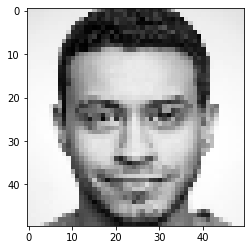

No Mask Detected


In [136]:
inputTest = 'D:/Project/4th year/Project files/Project/chettan no mask.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))

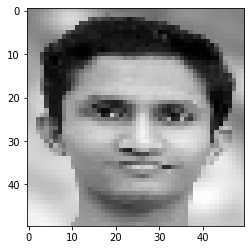

No Mask Detected


In [135]:
inputTest = 'D:/Project/4th year/Project files/Project/me no mask.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))

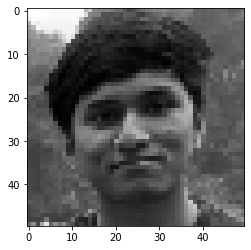

No Mask Detected


In [134]:
inputTest = 'D:/Project/4th year/Project files/Project/kiran no mask.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))

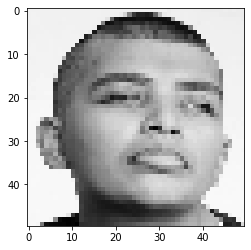

No Mask Detected


In [133]:
inputTest = 'D:/Project/4th year/Project files/Project/jiby no mask.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))

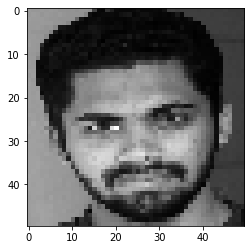

No Mask Detected


In [132]:
inputTest = 'D:/Project/4th year/Project files/Project/hamdan no mask.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))

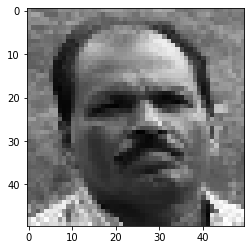

No Mask Detected


In [131]:
inputTest = 'D:/Project/4th year/Project files/Project/kirandad no mask.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))

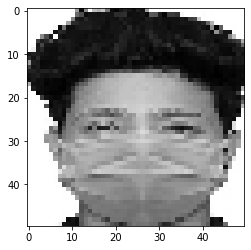

Mask Detected


In [130]:
inputTest = 'D:/Project/4th year/Project files/Project/mask face.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))

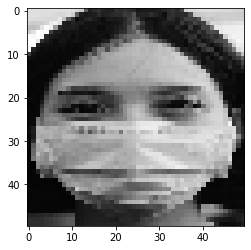

Mask Detected


In [129]:
inputTest = 'D:/Project/4th year/Project files/Project/mask face 2.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))

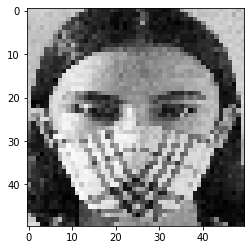

Mask Detected


In [128]:
inputTest = 'D:/Project/4th year/Project files/Project/mask face 3.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))

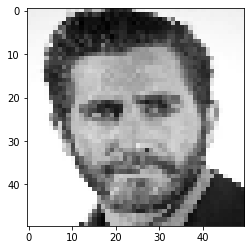

No Mask Detected


In [127]:
inputTest = 'D:/Project/4th year/Project files/Project/no mask.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))

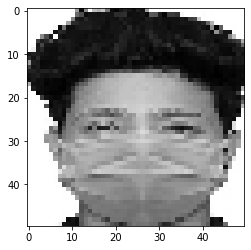

Mask Detected


In [125]:
inputTest = 'D:/Project/4th year/Project files/Project/mask face.jpg'
image = cv2.resize(cv2.imread(inputTest,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
image=image/255
plt.imshow(image,cmap='gray')
plt.show()
predict(model.predict(np.array(image).reshape(-1,IMG_SIZE,IMG_SIZE,1)))